In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from getdist import plots, MCSamples, loadMCSamples
import sys
sys.path.append('../')
import tqdm
from scipy.special import logsumexp
from sigw_fast.sigwfast import sigwfast_mod as gw
from math import sqrt
try:
    from sigw_fast.libraries import sdintegral_numba as sd
except ImportError:
    from sigw_fast.libraries import sdintegral as sd
# Set matplotlib parameters
font = {'size': 16, 'family': 'serif'}
axislabelfontsize = 'large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)
blue = '#006FED'
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [9]:
def plot_functional_posterior(vals,samples,k_arr = [], intervals=[99.7, 95., 68.],weights=None,
                              ylabels=[r'$P_{\zeta}$', r'$\Omega_{\rm GW}$'],
                              aspect_ratio=(6, 4.5),
                              interval_cols=[('#006FED', 0.2), ('#006FED', 0.4), ('#006FED', 0.6)]):
    # given a function y = f(k|x) with x~Posterior samples, plot the posterior of y at k_arr, with symmetric credible intervals

    nfuncs = len(vals)

    if weights is None:
        weights = np.ones(len(samples.shape[0]))

    fig, ax = plt.subplots(1,nfuncs,figsize=(aspect_ratio[0]*nfuncs,aspect_ratio[1]),constrained_layout=True)
    if nfuncs == 1:
        ax = [ax]
    for i,val in enumerate(vals):
        y = val # so y should have shape (nsamples, nk)
        for j,interval in enumerate(intervals):
            y_low, y_high = np.percentile(y,[50-interval/2,50+interval/2],axis=0,weights=weights,
                                          method='inverted_cdf')
            ax[i].fill_between(k_arr[i],y_low,y_high,color=interval_cols[j])
        # medians = np.apply_along_axis(weighted_median, 0, val, weights)
        # ax[i].plot(k_arr[i], medians, color='#006FED', lw=2.5)
        ax[i].plot(k_arr[i],np.median(y,axis=0),color=blue,lw=2)
        ax[i].set_ylabel(ylabels[i])
    for x in ax:
        x.set(xscale='log', yscale='log', xlabel=r'$f\,{\rm [Hz]}$')
    return fig, ax

def weighted_median(data, weights):
    """
    Compute the weighted median of data.
    """
    # Sort the data and weights.
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    # Compute the cumulative sum of the weights.
    cdf = np.cumsum(s_weights)
    # Find the median value.
    idx = np.searchsorted(cdf, 0.5)
    return s_data[idx]

def resample_equal(samples, logl, logwt, rstate):
    wt = np.exp(logwt)
    weights = wt / wt.sum()
    cumulative_sum = np.cumsum(weights)
    cumulative_sum /= cumulative_sum[-1]
    nsamples = len(weights)
    positions = (rstate.random() + np.arange(nsamples)) / nsamples
    idx = np.zeros(nsamples, dtype=int)
    i, j = 0, 0
    while i < nsamples:
        if positions[i] < cumulative_sum[j]:
            idx[i] = j
            i += 1
        else:
            j += 1
    perm = rstate.permutation(nsamples)
    resampled_samples = samples[idx][perm]
    resampled_logl = logl[idx][perm]
    return resampled_samples, resampled_logl

def compute_pz(k,samples,num_nodes,left_node,right_node):
    Pz = []
    num_free_nodes = num_nodes - 2
    for sample in tqdm.tqdm(samples,desc='Pz'):
        free_nodes = sample[2:num_free_nodes+2]
        lengthscale = sample[1]
        nodes = np.pad(free_nodes, (1,1), 'constant', constant_values=(left_node, right_node))
        vals = sample[num_free_nodes+2:]
        gpkernel = 1 * RBF(length_scale=lengthscale, length_scale_bounds="fixed") #+ np.eye(len(nodes)) * 1e-10
        gaussian_process = GaussianProcessRegressor(kernel=gpkernel, optimizer=None, normalize_y=True)
        gaussian_process.fit(nodes.reshape(-1, 1),vals)
        interp_nodes = np.linspace(nodes[0], nodes[-1], 100)
        interp_vals = gaussian_process.predict(interp_nodes.reshape(-1, 1))
        res = gw.power_spectrum_k_array(interp_nodes, interp_vals, k)
        Pz.append(res)
    return np.array(Pz)

In [10]:
# Load data
data = np.load('./spectra_0p66_interp.npz')
frequencies = data['frequencies']
gwb_model = 'bpl'
Omegas = data[f'gw_{gwb_model}'] 
kstar = 1e-3
omks_sigma = Omegas * (0.05 * (np.log(frequencies / kstar))**2 + 0.1)
cov = np.diag(omks_sigma**2)
pk_arr = data['pk_arr']
pk_min, pk_max = min(pk_arr), max(pk_arr)
left_node = np.log10(pk_min)
right_node = np.log10(pk_max)
p_arr = np.logspace(left_node+0.001, right_node-0.001, 100)
pz_amp = data[f'pk_{gwb_model}']
num_nodes = 4
# Load samples
sample_data = np.load(f'./{gwb_model}_w0p66_gp_{num_nodes}.npz')
samples = sample_data['samples']
logwt = sample_data['logwt']
logl = sample_data['logl']
omegagw = sample_data['omegagw']
weights_total = logsumexp(logwt)
weights = np.exp(logwt - weights_total)
weights = weights / np.sum(weights) 

print(f"Shapes: {samples.shape}, {logwt.shape}, {logl.shape}, {omegagw.shape}")


Shapes: (133000, 8), (133000,), (133000,), (133000, 50)


In [11]:
# resample to get equal weights
def resample_equal(samples, aux, logwt, rstate):
    wt = np.exp(logwt)
    weights = wt / wt.sum()
    cumulative_sum = np.cumsum(weights)
    cumulative_sum /= cumulative_sum[-1]
    nsamples = len(weights)
    positions = (rstate.random() + np.arange(nsamples)) / nsamples
    idx = np.zeros(nsamples, dtype=int)
    i, j = 0, 0
    while i < nsamples:
        if positions[i] < cumulative_sum[j]:
            idx[i] = j
            i += 1
        else:
            j += 1
    perm = rstate.permutation(nsamples)
    resampled_samples = samples[idx][perm]
    resampled_aux = aux[idx][perm]
    return resampled_samples, resampled_aux

equal_samples, equal_omegagw = resample_equal(samples, omegagw, logwt, np.random.RandomState(42))

print(f"Shapes: {equal_samples.shape}, {equal_omegagw.shape}")

num_thinned_samples = 4000
idxs = np.arange(equal_samples.shape[0])
thinned_samples_idxs = np.random.choice(idxs, num_thinned_samples, replace=False)
thinned_samples = equal_samples[thinned_samples_idxs]
thinned_weights = np.ones(num_thinned_samples)
thinned_omegagw = equal_omegagw[thinned_samples_idxs]

print(f"Shapes: {thinned_samples.shape}, {thinned_weights.shape}, {thinned_omegagw.shape}")

Shapes: (133000, 8), (133000, 50)
Shapes: (4000, 8), (4000,), (4000, 50)


In [12]:
pz_amps = compute_pz(p_arr, thinned_samples, num_nodes, left_node, right_node)

Pz: 100%|██████████| 4000/4000 [00:02<00:00, 1770.93it/s]


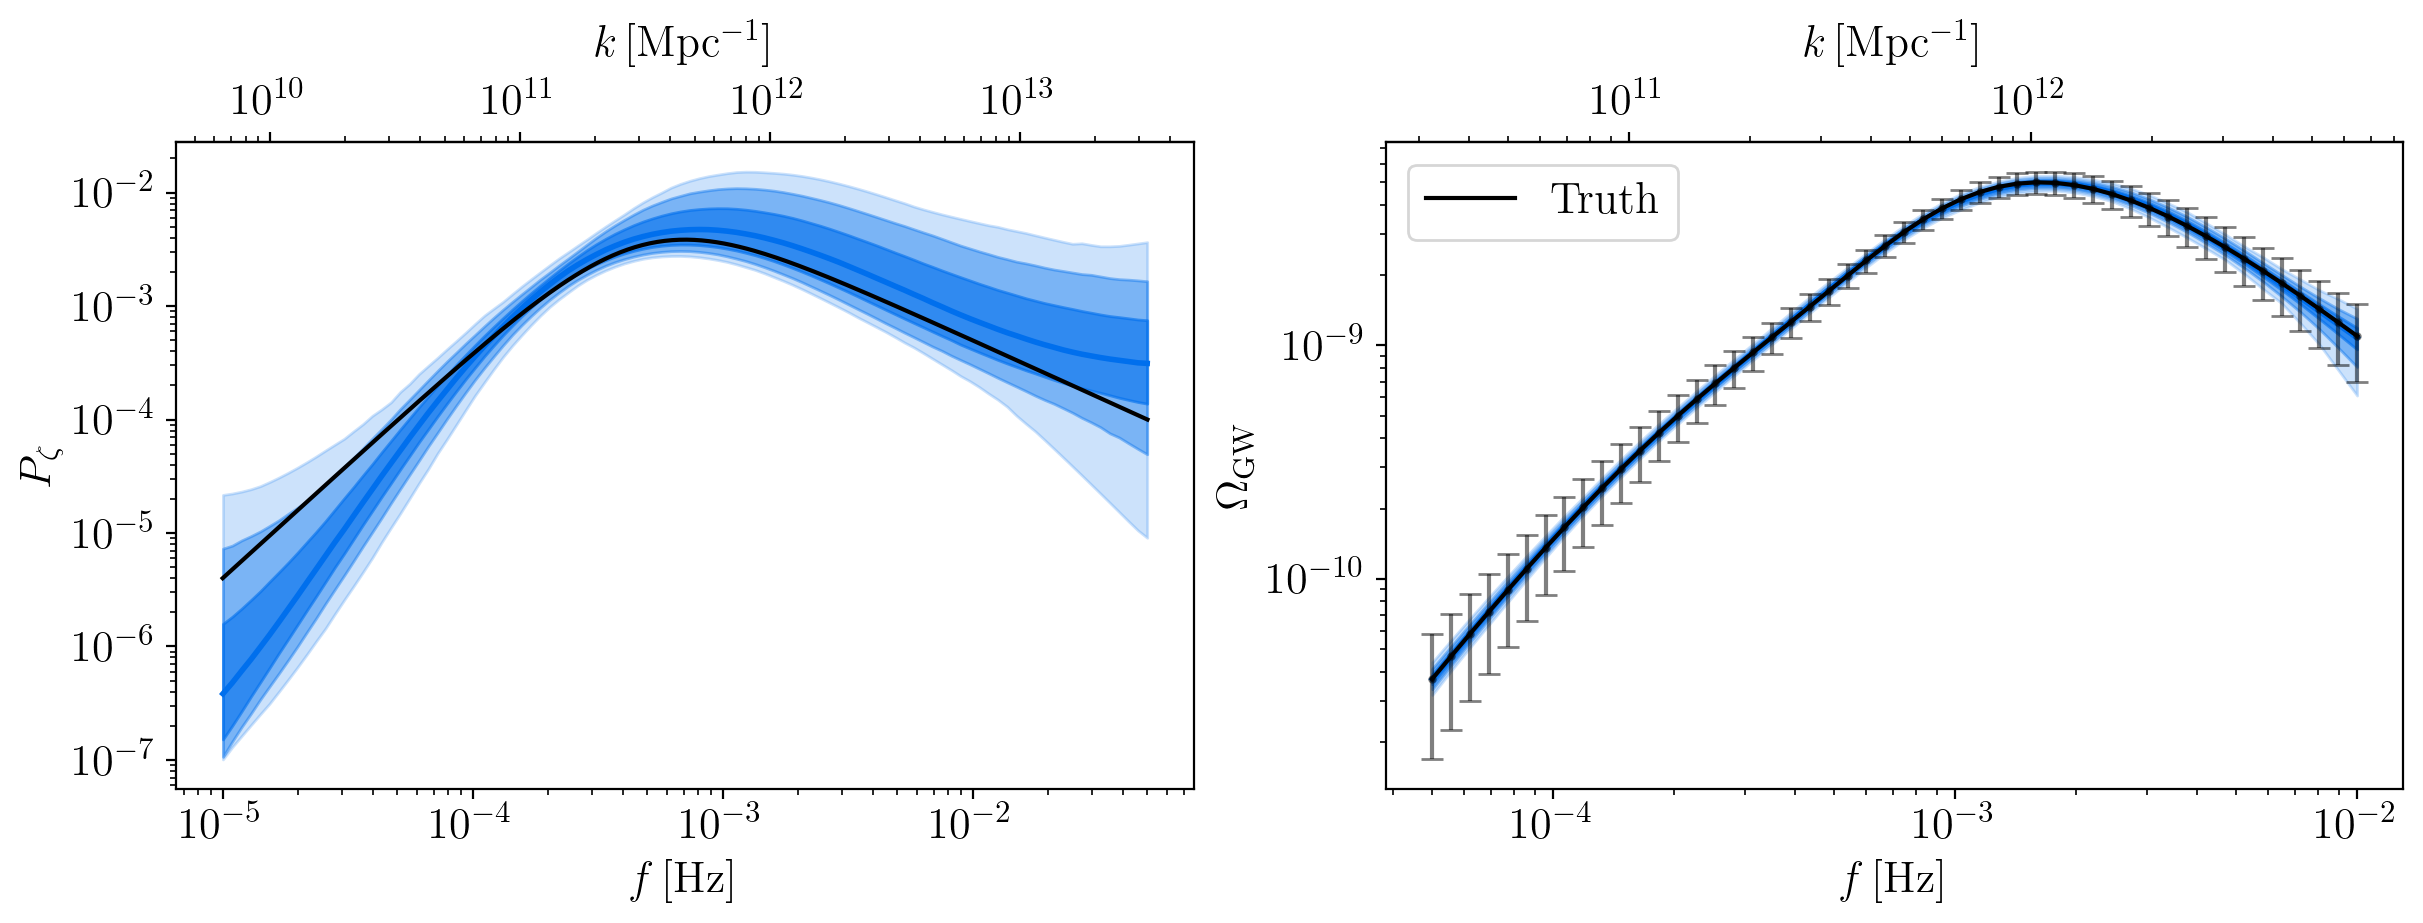

In [13]:
fig,ax = plot_functional_posterior([pz_amps,thinned_omegagw], thinned_samples, [p_arr,frequencies], weights=thinned_weights,)
ax[0].loglog(pk_arr,pz_amp, color='k', lw=1.5)
ax[1].loglog(frequencies, Omegas, color='k', lw=1.5, label='Truth')
ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt='o', color='k', capsize=4.,alpha=0.5,markersize=2)
ax[1].legend()
k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in ax:
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
plt.savefig(f'{gwb_model}_wfld_0p66_{num_nodes}_gp_posterior.pdf',bbox_inches='tight')


{'w': [0.4, 0.99]}
Removed no burn in
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
w           5.9716456E-01  8.5617489E-02  5.2094461E-01  7.0265523E-01  two    4.3685469E-01  7.4419395E-01  two    4.0007905E-01  7.6299242E-01  two     w



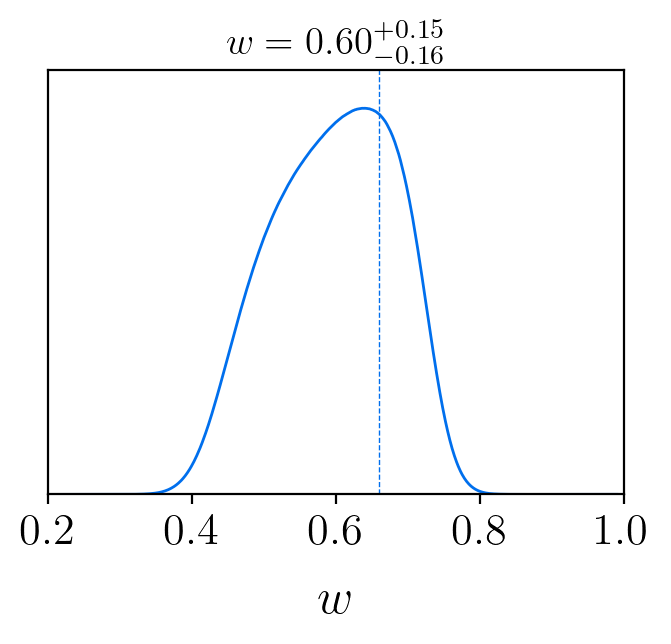

In [15]:
w = 0.66
names = ['w']
labels = ['w']
bounds = [[0.4,0.99]]
ranges = dict(zip(names,bounds))
print(ranges)
# ws = samples[:,0]
# ws = ws[samples[:,0] < 0.9]
# w_weights = weights[samples[:,0] < 0.9]
# print(f"Shapes: {ws.shape}, {weights.shape}")
# # gd_samples = MCSamples(samples=samples[:,0], names=names, labels=labels,ranges=ranges,weights=normalized_weights,loglikes=logl)
# gd_samples = MCSamples(samples=ws, names=names, labels=labels,ranges=ranges,weights=w_weights)
gd_samples = MCSamples(samples=samples[:,0], names=names, labels=labels,ranges=ranges,weights=weights)
g = plots.get_subplot_plotter(subplot_size=3.5)
blue = '#006FED'
g.settings.title_limit_fontsize = 14
g.settings.axes_fontsize=16
g.settings.axes_labelsize=18
g.plot_1d(gd_samples, 'w', marker=w, marker_color=blue, colors=[blue],title_limit=2)
g.export(f'{gwb_model}_wfld_0p66_{num_nodes}_gp_1D_w.pdf')
ax = g.subplots[0,0]
ax.set_xlim(0.2, 1.0)
print(gd_samples.getMargeStats())
